 <h3 align="center">Eddy Heat Fluxes</h3> 

1$^{st}$ break down = simple mean and eddy components

$v\,=\, \overline{v}+v'$

$T\,=\,\overline{T}+T'$

Total Heat Flux: $C_p\,\rho \, \iint \overline{vT}\, dA$

Mean Heat Flux= $C_p\,\rho \, \iint \overline{v}\overline{T}\, dA$

Eddy Heat Flux= $C_p\,\rho \, \iint \overline{v'T'}\, dA$



In [1]:
%install_ext https://raw.githubusercontent.com/SiggyF/notebooks/master/pep8_magic.py
%load_ext pep8_magic

Installed pep8_magic.py. To use it, type:
  %load_ext pep8_magic


In [11]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
import math
from pylab import *
import glob
from scipy.interpolate import interp1d
import matplotlib.gridspec as gridspec
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from useful import *
import layers_calc_numba
from Flat_channel import *
from HB_Plot import nf, fmt
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

In [12]:
Full = 'N'

In [13]:
if Full == 'N':
    tau = ['3', '300', '3000', 'Closed']
    #tau = ['3', 'Closed']
    #tau = ['3', '300']
    # tau=['NoQ']
else:
    tau = ['3', '10', '30', '100', '300',
           '1000', '3000', '10000', 'Closed']
Figletter = ['a) ', 'b) ', 'c) ', 'd) ', 'e) ',
             'f) ', 'g) ', 'h) ', 'i) ']
# x = '/hpcdata/scratch/hb1g13/NchannelFlat'
x = '/noc/msm/scratch/students/hb1g13/Mobilis'


# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()
# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r $^oC$ %'
else:
    fmt = '%r $^oC$'
# Now Make file structure
check = 0
runs = []
check=0
runs=[]
for i in range(len(tau)):
    flist=x+'/'+str(tau[i])+'daynokpp/VTprimebar.nc'
    if not os.path.exists(flist):
        print 'WARNING: '+flist+' does not exist! (skipping this tau...)'
        check+=0
    else:
        check+=1
        runs.append(i)
Runs = np.array(runs)
# Set Parameters
alpha = 2.000000E-04
g = -9.81
rho_0 = 1000
C_p = 3985
gridfilepath = x+'/'+str(tau[0])+'daynokpp/'
file2 = netCDF4.Dataset(gridfilepath+'grid.nc', 'r')
Zp = file2.variables['Zp1'][:]
Z = file2.variables['Z'][:]
Y = file2.variables['Yp1'][:]
Yc = file2.variables['Y'][:]
Zmatrix = np.zeros((len(Z), len(Yc)))
Zmatrix[:, :] = 1
dx = Y[1]-Y[0]  # Find Resolution
dz = Zp[0:len(Zp)-1]-Zp[1:len(Zp)]
dA=dz*5000
y = Yc/1000
Zmatrix = np.apply_along_axis(np.multiply, 0, Zmatrix, dz)
pi = math.pi
exp = np.exp

$C_p\,\rho \, \iint \overline{v'T'}\, dA$

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:35: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:35: RuntimeWarning: invalid value encountered in divide


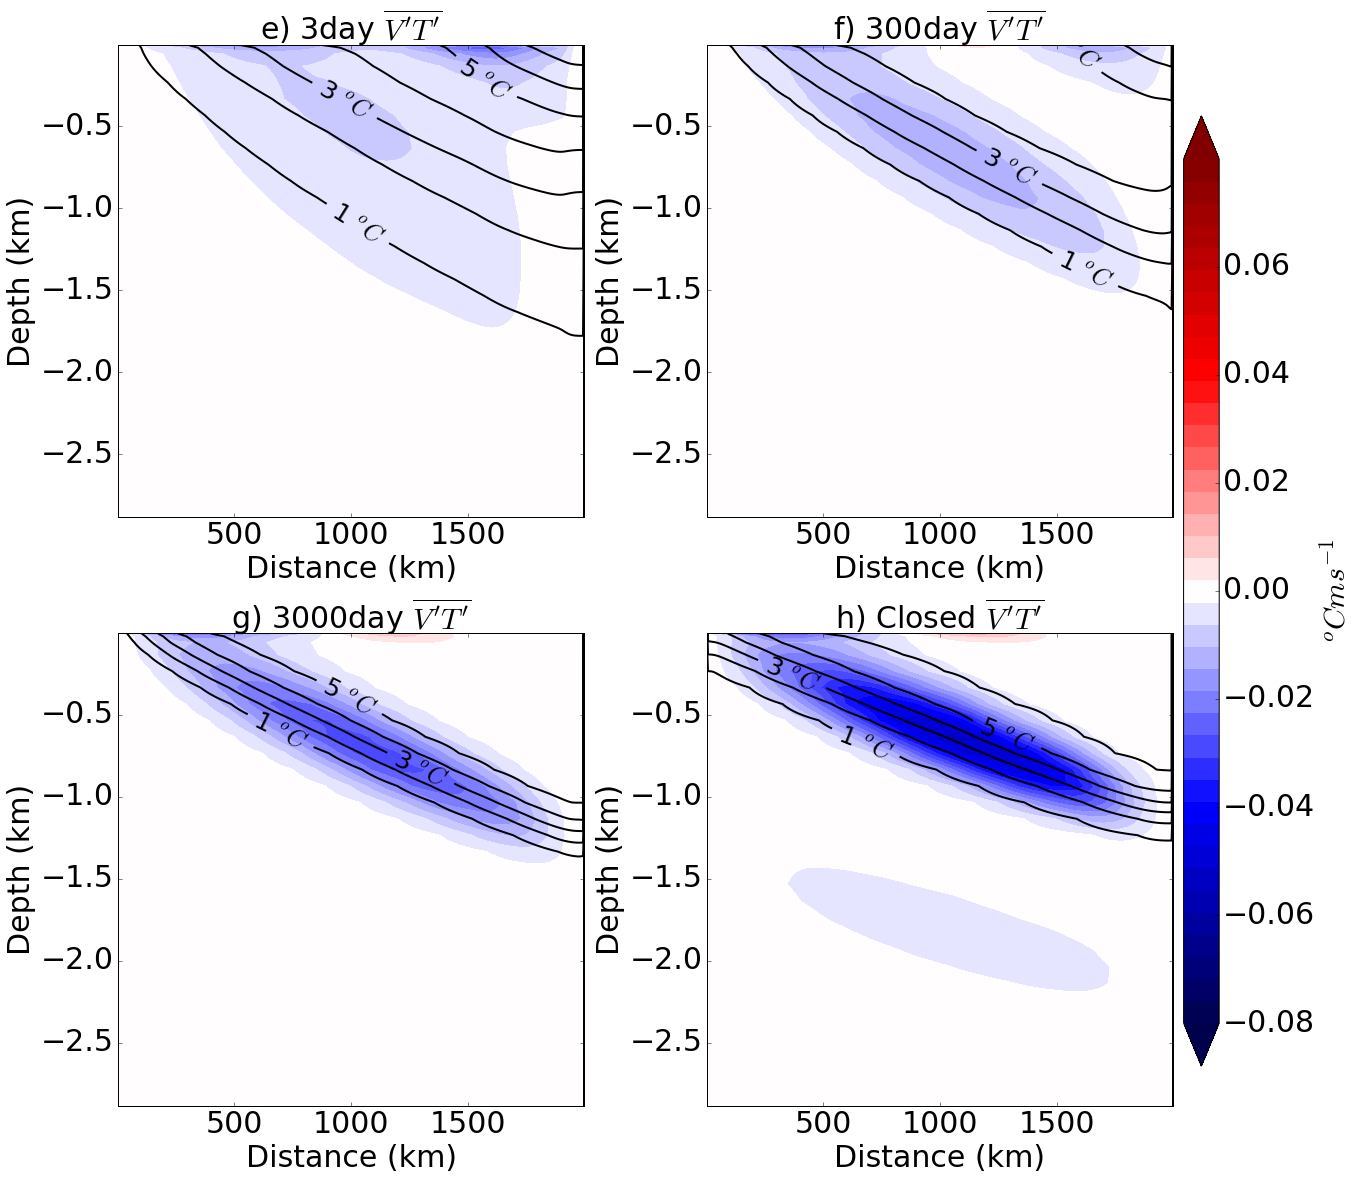

In [29]:
fig = plt.figure(figsize=(16.5, 16.5))
# Create Panels
Psi_levs = np.arange(-2., 2., .21)
Psi_ticks =np.arange(-2., 2., .5)
Q_levs = (arange(-.08,0.081,0.0041))
Q_ticks = np.arange(-.08, 0.08, .02)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar                                                                                                                    
    # put everything on the C Grid                                                                                                        
    T = c.mnc('Tav.nc','THETA')
    V = c.vgrid_to_cgrid(c.mnc('Tav.nc','VVEL'))
    W = c.mnc('Tav.nc','WVEL')

    VT= c.vgrid_to_cgrid(c.mnc('Tav_VT.nc','VVELTH'))
    WT= c.mnc('Tav_VT.nc','WVELTH')
    npad = ((1, 0), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VpTp = ( (VT) - V*T ).mean(axis=2)
    WpTp = ( c.wgrid_to_cgrid(WT) - c.wgrid_to_cgrid(W)*T ).mean(axis=2)
    
    
    # mean zonal flow                                                                                                                     
    Ubar = c.mnc('Tav.nc','UVEL').mean(axis=2)
    Ubc = Ubar - tile(Ubar[-1,:],(Nz,1))
    Tbar = T.mean(axis=2)
    Ty = c.ddy_cgrid_centered(Tbar)
    Tz = c.ddz_cgrid_centered(Tbar)
    S = - Ty / Tz

    Kb = VpTp 
    bfac = 9.8*2e-4

    #title(r'$K_b$ (m$^2$s$^{-1}$)', fontsize=30 )
    ax = fig.add_subplot(2, 2, i+1)
    Q2_levs = (np.arange(-1,8,1))
    p = ax.contourf(c.yc/1000, c.zc/1000, Kb , Q_levs, cmap=plt.cm.seismic, extend='both')
    Tzone = T.mean(axis=2)
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        Tzone = np.apply_along_axis(np.divide, 0, Tzone, 4-np.sum(tRef*dz)/-Z[-1])
    q = ax.contour(c.yc/1000, c.zc/1000, Tzone, Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[i+4])+str(tau[Runs[i]])+r'day $\overline{V ^\prime T ^\prime}$', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[i+4])+str(tau[Runs[i]])+r' $\overline{V ^\prime T ^\prime}$', fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Q_ticks)
cbar.ax.set_ylabel(r'$^o C m s^{-1}$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

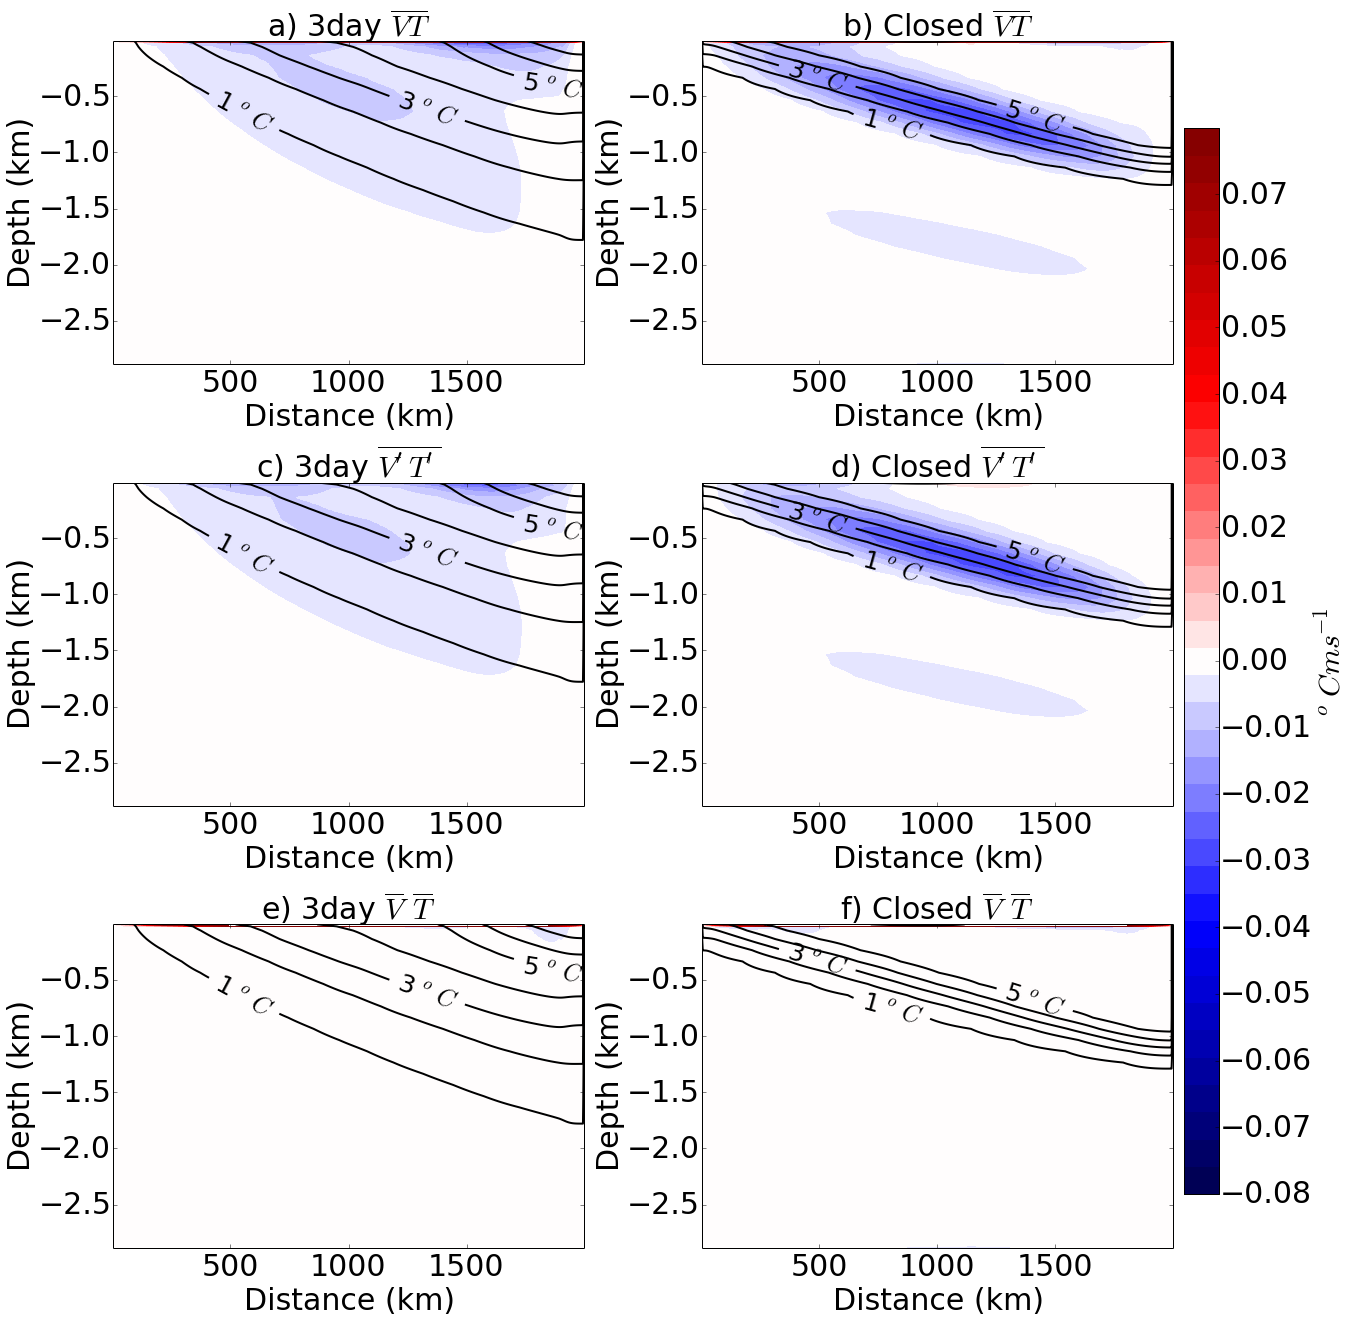

In [5]:
fig = plt.figure(figsize=(16.5, 18.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/VTbar.nc'
    file2read = netCDF4.Dataset(fname, 'r')
    VT = file2read.variables['VT'][:]
    VTzone = np.mean(VT, axis=2)
    VTdA = np.cumsum((Zmatrix*VTzone)[::-1],axis=0)[::-1]
    filename = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2read = netCDF4.Dataset(filename, 'r')
    Temp = file2read.variables["THETA"][:]
    Vtav = file2read.variables["VVEL"][:]
    Vzone = np.mean(np.mean(Vtav, axis=0), axis=2)
    Tzone = np.mean(np.mean(Temp, axis=0), axis=2)
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        Tzone = np.apply_along_axis(np.divide, 0, Tzone, 4-np.sum(tRef*dz)/-Z[-1])
    VTM = hb.numba_regridy(Vzone)*(Tzone)
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/VTprimebar.nc'
    file2read = netCDF4.Dataset(fname, 'r')
    VT = file2read.variables['VT'][:]
    Ed =np.mean(VT, axis=2)
    Q2_levs = (np.arange(1, 8, 1))
    y = Yc/1000
    Q_levs = np.arange(-0.08, 0.08, 0.0041)
    Q_ticks = np.arange(-0.08, 0.08, 0.01)
    ax = fig.add_subplot(3, 2, i+1)
    p = ax.contourf(y, Z/1000, VTzone,
                    Q_levs, cmap=plt.cm.seismic)  # Use b2r colourmap
    q = ax.contour(Yc/1000, Z/1000, Tzone,
                   Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[i])+str(tau[Runs[i]])+r'day $\overline{VT}$', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[i])+str(tau[Runs[i]])+r' $\overline{VT}$', fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax = fig.add_subplot(3, 2, i+3)
    p = ax.contourf(y, Z/1000, Ed,
                    Q_levs, cmap=plt.cm.seismic)  # Use b2r colourmap
    q = ax.contour(Yc/1000, Z/1000, Tzone,
                   Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[i+2])+str(tau[Runs[i]])+r'day $\overline{V^\prime T^\prime }$ ', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[i+2])+str(tau[Runs[i]])+r' $\overline{V^\prime T^\prime }$', fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax = fig.add_subplot(3, 2, i+5)
    p = ax.contourf(y, Z/1000, VTM,
                    Q_levs, cmap=plt.cm.seismic)  # Use b2r colourmap
    q = ax.contour(Yc/1000, Z/1000, Tzone,
                   Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[i+4])+str(tau[Runs[i]])+r'day $\overline{V}\,\overline{T}$', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[i+4])+str(tau[Runs[i]])+r' $\overline{V}\,\overline{T}$', fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Q_ticks)
cbar.ax.set_ylabel(r'$ ^oC m s^{-1}$', fontsize=30)
cbar.ax.tick_params(labelsize=30)


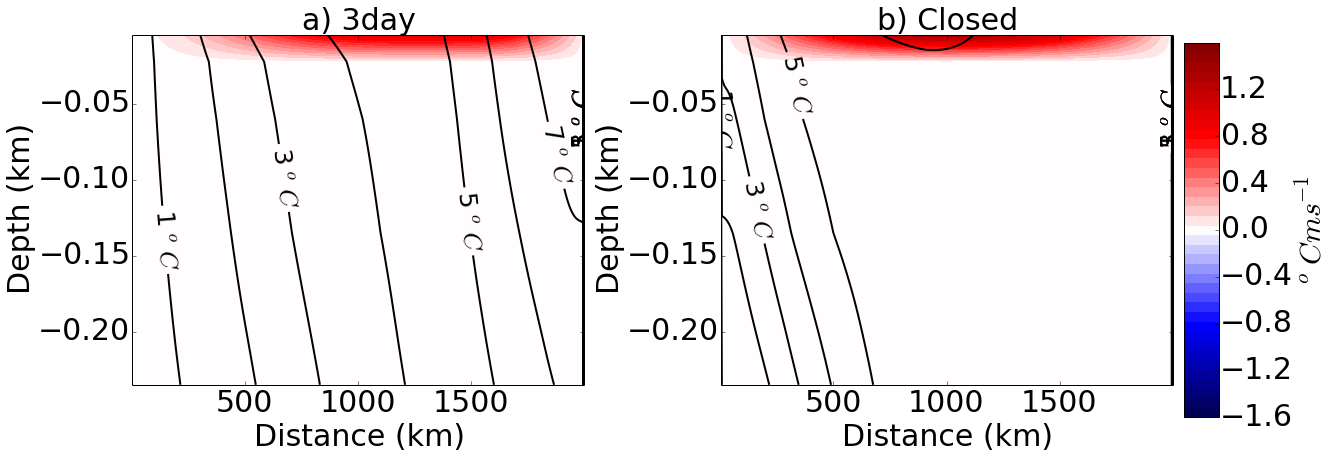

In [6]:
fig = plt.figure(figsize=(16.5, 6.5))
for i in range(len(Runs)):
    filename = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2read = netCDF4.Dataset(filename, 'r')
    Temp = file2read.variables["THETA"][:]
    Vtav = file2read.variables["VVEL"][:]
    Tzone = np.mean(np.mean(Temp, axis=0), axis=2)
    Vzone = np.mean(np.mean(Vtav, axis=0), axis=2)
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        Tzone = np.apply_along_axis(np.divide, 0, Tzone, 4-np.sum(tRef*dz)/-Z[-1])
    #Tzone[Tzone<0.5] = 0.0
    VT = hb.numba_regridy(Vzone)*Tzone
    VTdA = np.cumsum((VT*Zmatrix)[::-1],axis=0)[::-1]
    Q2_levs = (np.arange(1, 8, 1))
    y = Yc/1000
    Q_levs = np.arange(-0.08, 0.08, 0.0041)*20
    Q_ticks = np.arange(-0.08, 0.08, 0.02)*20
    ax = fig.add_subplot(1, 2, i+1)
    p = ax.contourf(y, Z[0:5]/1000, VT[0:5,:],
                    Q_levs,cmap=plt.cm.seismic)  # Use b2r colourmap
    q = ax.contour(Yc/1000, Z[0:5]/1000, Tzone[0:5,:],
                   Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Q_ticks)
cbar.ax.set_ylabel(r'$ ^oC m s^{-1}$', fontsize=30)
cbar.ax.tick_params(labelsize=30)

## Diabatic Eddy ##

/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:33: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:46: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:47: RuntimeWarning: invalid value encountered in subtract


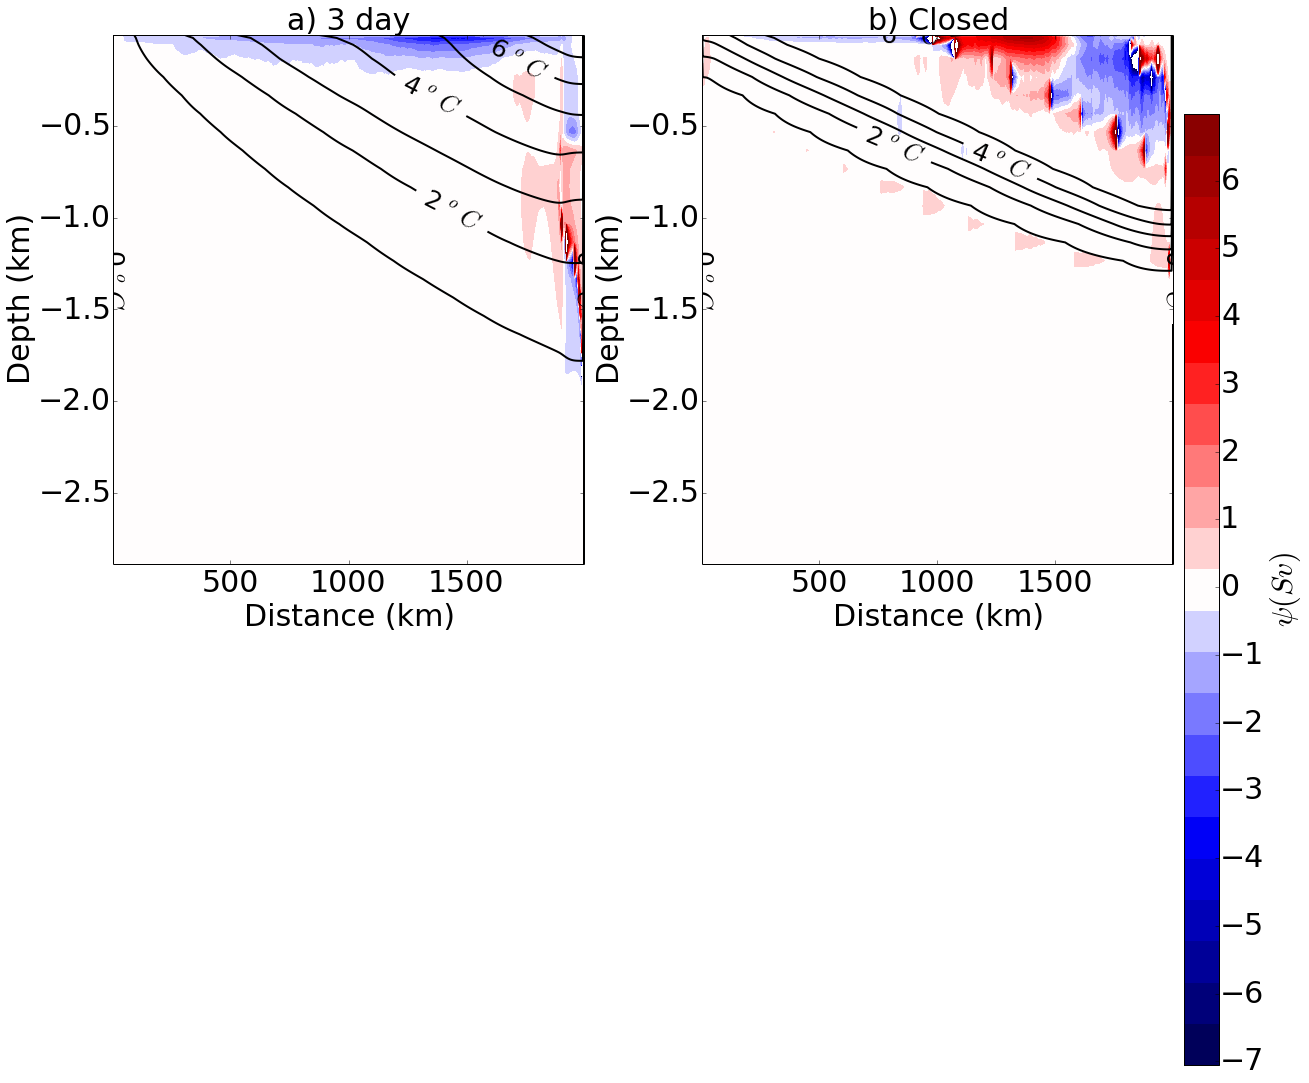

In [8]:
fig=plt.figure(figsize=(16.5,16.5))
for i in range(len(Runs)):
    fname=x+'/'+str(tau[Runs[i]])+'daynokpp/WTprimebar.nc'
    if not os.path.isfile(fname):
        continue
    file2read = netCDF4.Dataset(fname,'r')
    VT=file2read.variables['WT']
    VTzone=np.mean(VT[:]*1,axis=2)
    VTdA=VTzone
    filename=x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2read = netCDF4.Dataset(filename,'r')
    Temp=file2read.variables["THETA"] 
    Temp=Temp[:]
    Tzone=np.mean(np.mean(Temp,axis=0),axis = 2)
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        Tzone = np.apply_along_axis(np.divide, 0, Tzone, 4-np.sum(tRef*dz)/-Z[-1])
    #Interpolate
    bz, by = np.gradient(Tzone)
    bz = bz / Zmatrix
    #bz[np.round(bz,5) == 0]=np.nan
    by = by/5000
    #by[np.round(by,8) == 0]=np.nan
    Q2_levs = (np.arange(0.1,8.1,1))
    y=Y/1000
    Q_levs = np.arange(-3.55,3.55,0.42)
    Q_ticks = np.arange(-5,1.0,0.6)
    ED1=-VTzone/by*5000*10**-6*200
    fname=x+'/'+str(tau[Runs[i]])+'daynokpp/VTprimebar.nc'
    if not os.path.isfile(fname):
        continue
    file2read = netCDF4.Dataset(fname,'r')
    VT=file2read.variables['VT']
    VTzone=np.mean(VT[:]*1,axis=2)
    VTdA=VTzone/Zmatrix
    Q2_levs = (np.arange(0.,8.1,1))
    y=Y/1000
    Q_levs = np.arange(-7.05,7.05,0.61)
    Q_ticks = np.arange(-7.0,7.0,1.)
    ax = fig.add_subplot(2, 2, i+1)
    ED=-VTdA/bz*Zmatrix*5000*10**-6*200 #Volume and sum channel in x
    DEds = ED-ED1
    DEds[Tzone<.8] = 0.0
    ax = fig.add_subplot(2, 2, i+1)
    p=ax.contourf(Yc/1000,Z[:]/1000,DEds,Q_levs,cmap=plt.cm.seismic) #Use b2r colourmap
    q=ax.contour(Yc/1000,Z[:]/1000,Tzone[:],Q2_levs,colors='k',linewidths = 2)
    q.levels = [nf(val) for val in q.levels ]
    plt.clabel(q,q.levels[::2], inline=1,fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]]) + str(tau[Runs[i]])+' day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]]) + str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar=fig.colorbar(p, cax=cax, ticks=Q_ticks)
cbar.ax.set_ylabel(r'$ \psi (Sv)$', fontsize=30)
cbar.ax.tick_params(labelsize=30)